# Toxicity Target Classification

In this notebook, we will train a baseline model to predict if a toxic comment is targeted or not.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

## Imports

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [4]:
import logging
import numpy as np
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda import is_available
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from simpletransformers.classification import (
    ClassificationModel,
    ClassificationArgs
)

from src.modeling.utils import (
    download_dataset,
    get_dataset_version,
    prep_data,
    clean_simpletransformers
)

%matplotlib inline

sns.set_theme(style="whitegrid", palette="pastel")

logging.basicConfig(level=logging.INFO)

_logger = logging.getLogger("transformers")
_logger.setLevel(logging.WARNING)

params = {
    "seed": 1993,
    "model_type": "bert",
    "model_name": "neuralmind/bert-base-portuguese-cased",
    "num_train_epochs": 6,
    "test_size": 0.3,
    "use_cuda": is_available()
}

In [5]:
experiment_name = "toxicity_target_classification"

mlflow.set_experiment(experiment_name)

mlflow.start_run(tags={"project": "olid-br"})

2022/06/26 21:05:20 INFO mlflow.tracking.fluent: Experiment with name 'toxicity-target-classification' does not exist. Creating a new experiment.


<ActiveRun: >

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [7]:
df = download_dataset()

mlflow.log_param("dataset_version", f"v{get_dataset_version()}")

print(f"Shape: {df.shape}")
df.head()

Shape: (4676, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


We need to filter out the comments that are not toxic.

In [8]:
df = df[df["is_offensive"] == "OFF"]
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape}")

Shape: (4129, 17)


## Exploratory Data Analysis (EDA)

In the next section, we will perform some exploratory data analysis (EDA) to understand the data.

In [9]:
df_eda = df[["text", "is_targeted"]].groupby("is_targeted").count()
df_eda.reset_index(inplace=True)
df_eda

,is_targeted,text
0,TIN,2750
1,UNT,1379


INFO:botocore.credentials:Found credentials in environment variables.


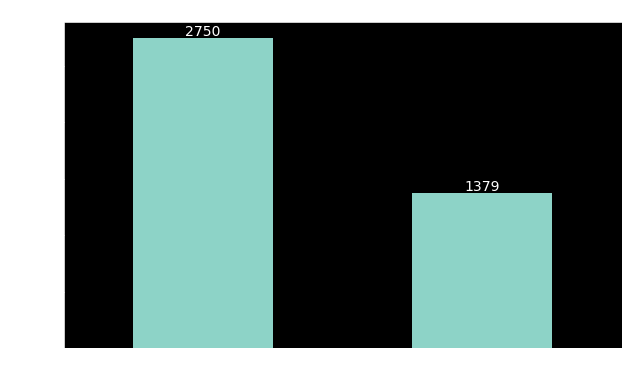

In [10]:
ax = df_eda.plot(x="is_targeted", y="text", kind="bar", legend=False, figsize=(10, 6),
                 xlabel="is_targeted", ylabel="count", fontsize=14, grid=False,
                 rot=1, title="is_targeted distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=12)

mlflow.log_figure(
    figure=ax.get_figure(),
    artifact_file="is_targeted_distribution.png")

In [11]:
classes = {
    0: "UNT",
    1: "TIN"
}

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [12]:
X = df["text"].values
y = df["is_targeted"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=params["test_size"],
                                                    random_state=params["seed"],
                                                    stratify=y)

train_data = prep_data(X_train, y_train, classes)
test_data = prep_data(X_test, y_test, classes)

df_train = pd.DataFrame(train_data)
df_train.columns = ["text", "labels"]

df_test = pd.DataFrame(test_data)
df_test.columns = ["text", "labels"]

mlflow.log_param("train_size", len(df_train))
mlflow.log_param("test_size", len(df_test))

print(f"train_data: {df_train.shape}")
print(f"test_data: {df_test.shape}")

train_data: (2890, 2)
test_data: (1239, 2)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [13]:
clean_simpletransformers()

# Compute class weights
params["class_weights"] = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train)

# Optional model configuration
model_args = ClassificationArgs(
    num_train_epochs=params["num_train_epochs"])

mlflow.log_params(model_args.__dict__)

# Create a ClassificationModel
model = ClassificationModel(
    model_type=params["model_type"],
    model_name=params["model_name"],
    args=model_args,
    weight=list(params["class_weights"]),
    use_cuda=params["use_cuda"]
)

# Train the model
model.train_model(df_train)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

  0%|          | 0/2890 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_128_2_2
c:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/362 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of bert model complete. Saved to outputs/.


(362, 0.525367999974206)

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;

In [14]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1239 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2


Running Evaluation:   0%|          | 0/155 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.10582292598137362, 'tp': 819, 'tn': 15, 'fp': 399, 'fn': 6, 'auroc': 0.6236729614990484, 'auprc': 0.7592196334819952, 'eval_loss': 0.5125931970534786}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1239 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

In [15]:
# Logging metrics in MLflow
metrics = classification_report(
    y_true, y_pred, digits=4,
    target_names=classes.values(), output_dict=True)

mlflow.log_metric("auroc", result["auroc"])
mlflow.log_metric("accuracy", metrics["accuracy"])
mlflow.log_metric("weighted_f1_score", metrics["weighted avg"]["f1-score"])
mlflow.log_metric("weighted_precision", metrics["weighted avg"]["precision"])
mlflow.log_metric("weighted_recall", metrics["weighted avg"]["recall"])

mlflow.log_metric("UNT_precision", metrics["UNT"]["precision"])
mlflow.log_metric("UNT_recall", metrics["UNT"]["recall"])
mlflow.log_metric("UNT_f1_score", metrics["UNT"]["f1-score"])
mlflow.log_metric("TIN_precision", metrics["TIN"]["precision"])
mlflow.log_metric("TIN_recall", metrics["TIN"]["recall"])
mlflow.log_metric("TIN_f1_score", metrics["TIN"]["f1-score"])

## Testing the model

In this section, we will test the model with some comments from the test set.

In [16]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].map(classes)
df_pred["predictions"] = df_pred["predictions"].map(classes)

df_pred

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,text,labels,predictions
0,"Isso, deixa a pessoa falar que é nazista em pa...",TIN,TIN
1,"sinceramente, acho que esse canal deveria acab...",TIN,TIN
2,Viciado-Vampiro vampiro vampiro omg vampiro va...,UNT,TIN
3,USER USER Nada haver religião com político dem...,TIN,TIN
4,"“Me mama el puto exceso, vamos a matarnos” - E...",TIN,TIN
5,"Uma palhaçada isUSER, USER no brasil existe is...",TIN,TIN
6,"oh burro, como é que não me lembrei da loja ao...",UNT,TIN
7,psicopatas suicidas atrás de um louco bipolar aff,TIN,TIN
8,USER USER Hoje é esse lance que vc falou. Vaga...,TIN,TIN
9,"USER merda, ridículo essa imposição. Pior aind...",UNT,TIN


## Register model in MLflow

In this section, we will register the model in MLflow.

In [24]:
def get_conda_env():
    import torch
    from mlflow.utils.environment import _mlflow_conda_env

    conda_env = _mlflow_conda_env(
        additional_conda_deps=[
            f"pytorch={torch.__version__}",
            "simpletransformers==0.63.7"
        ]
    )

    return conda_env

mlflow.pytorch.log_model(
    pytorch_model=model.model,
    conda_env=get_conda_env(),
    artifact_path="model",
    registered_model_name=experiment_name)

Successfully registered model 'toxicity_target_classification'.
2022/06/26 22:13:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: toxicity_target_classification, version 1
Created version '1' of model 'toxicity_target_classification'.


ModelInfo(artifact_path='model', flavors={'pytorch': {'model_data': 'data', 'pytorch_version': '1.11.0', 'code': None}, 'python_function': {'pickle_module_name': 'mlflow.pytorch.pickle_module', 'loader_module': 'mlflow.pytorch', 'python_version': '3.9.12', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/cda57811e77d4ef79a30c2ec06aaf8a3/model', model_uuid='8b18b55f851a4799977ae235566b501e', run_id='cda57811e77d4ef79a30c2ec06aaf8a3', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-06-27 01:12:50.510258', mlflow_version='1.26.1')

In [25]:
clean_simpletransformers()

mlflow.end_run()